In [1]:
import mplhep as hep
from distributed import Client
from egamma_tnp import TagNProbe
from egamma_tnp.plot import plot_efficiency
from matplotlib import pyplot as plt

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

In [2]:
%%time
# tag_n_probe = TagNProbe(
#     "/EGamma*/Run2023C-PromptNanoAODv12_v4-v1/NANOAOD",
#     goldenjson="json/Cert_Collisions2023_366442_368823_Golden.json",
#     toquery=True,
#     redirect=False,
# )

tag_n_probe = TagNProbe(
    ["root_files/Egamma0.root", "root_files/Egamma1.root"],
    goldenjson="json/Cert_Collisions2023_366442_368823_Golden.json",
    toquery=False,
    redirect=False,
)


tag_n_probe.remove_bad_xrootd_files(
    [
        "root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma0/NANOAOD/PromptNanoAODv12_v4-v1/70000/a1e1c26c-4328-4147-a247-cb8fa85c0d04.root",
        "root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma1/NANOAOD/PromptNanoAODv12_v4-v1/2810000/c0e3ecf9-d65e-440b-acb9-af89a073a217.root",
    ]
)
tag_n_probe.load_events()
tag_n_probe

CPU times: user 844 ms, sys: 27.3 ms, total: 872 ms
Wall time: 882 ms


TagNProbe(Events: dask.awkward<from-uproot, npartitions=2>, Number of files: 2, Golden JSON: json/Cert_Collisions2023_366442_368823_Golden.json)

In [3]:
%%time

with Client() as client:
    (
        hpt_pass,
        hpt_all,
        heta_pass,
        heta_all,
    ) = tag_n_probe.get_tnp_histograms(compute=True, scheduler=None, progress=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

[########################################] | 100% Completed | 213.53 ms
Passing probes: 14598.0
All probes: 16896.0
CPU times: user 1.85 s, sys: 177 ms, total: 2.03 s
Wall time: 7.41 s


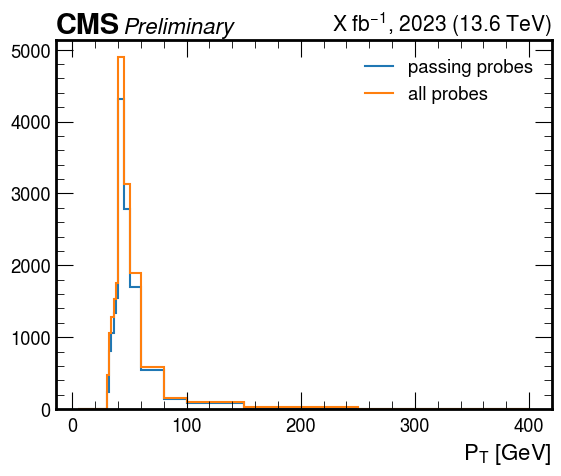

In [4]:
hpt_pass.plot1d(label="passing probes", flow="none")
hpt_all.plot1d(label="all probes", flow="none")
plt.xlabel(r"$P_T$ [GeV]")
plt.legend()
plt.savefig("plots/pt.pdf", bbox_inches="tight")
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

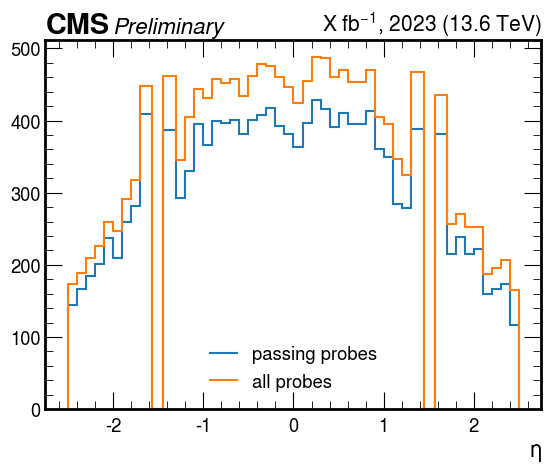

In [5]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlabel(r"$\eta$")
plt.legend()
plt.savefig("plots/eta.pdf", bbox_inches="tight")
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

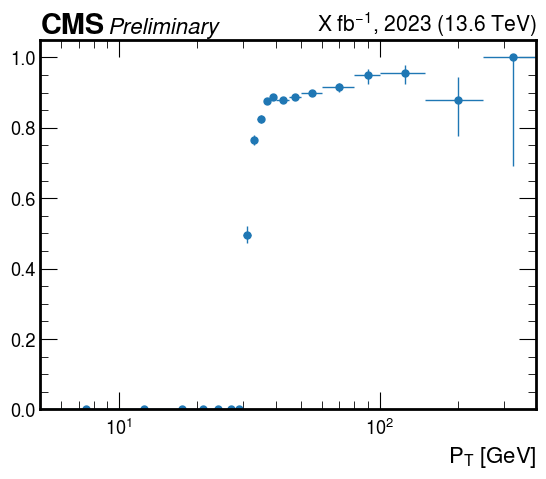

In [6]:
plot_efficiency(hpt_pass, hpt_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.xscale("log")
plt.savefig("plots/eff_pt.pdf")
plt.show()

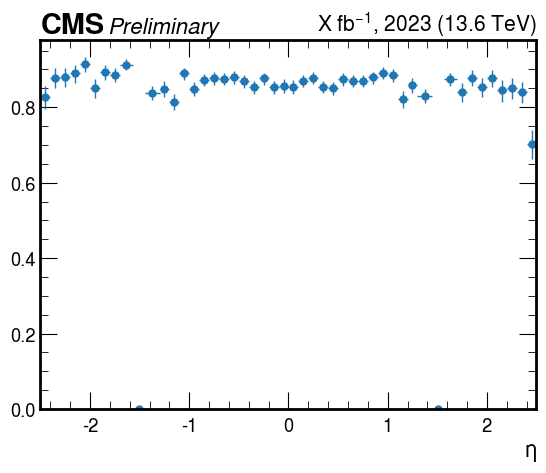

In [7]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.savefig("plots/eff_eta.pdf")
plt.show()